# PSILOCYBIN MICE

In [1]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
adata = sc.read_10x_mtx("/Users/npapadop/Documents/teaching/2024/GSE246451/saline/")
adata.obs.index = adata.obs.index + "-sal"
adata.obs["condition"] = "saline"

In [4]:
adata

AnnData object with n_obs × n_vars = 3539949 × 32285
    obs: 'condition'
    var: 'gene_ids', 'feature_types'

filtering instructions: remove

- #features < 700
- %mito > 5
- doublets (DoubletFinder)

It turns out the matrix is too big for our paltry laptops. Let's believe the authors, and filter by #features first:

In [5]:
no_features_expressed = np.array(np.sum(adata.X > 0, axis=1))[:, 0]

In [6]:
keep = no_features_expressed > 700

actually subset:

In [7]:
adata = adata[keep].copy()

now let's annotate mitochondrial genes:

In [8]:
adata.var["mitochondrial"] = adata.var.index.str.contains("mt-")

calculate basic QC metrics:

In [9]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mitochondrial"], inplace=True)

Now actually filter for mitochondrial percentage:

In [10]:
adata.shape

(11907, 32285)

In [11]:
keep = adata.obs["pct_counts_mitochondrial"] <= 5
adata = adata[keep].copy()

In [12]:
adata.shape

(11899, 32285)

First let's make a backup of the raw counts so that we can reset, if needed.

In [13]:
adata.layers["counts"] = adata.X.copy()

# normalisation!

In [14]:
# this is for distance calculations
sc.experimental.pp.recipe_pearson_residuals(adata, n_comps=80, n_top_genes=3000)
# this is for gene expression testing
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata # we don't need to do .copy() here and can get away with just referencing, but this is usually dangerous

In [15]:
adata.obsm["X_pca"].shape

(11899, 80)

In [16]:
sc.pp.neighbors(adata, n_pcs=50)
sc.tl.umap(adata, min_dist=0.1)

In [17]:
%matplotlib inline

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


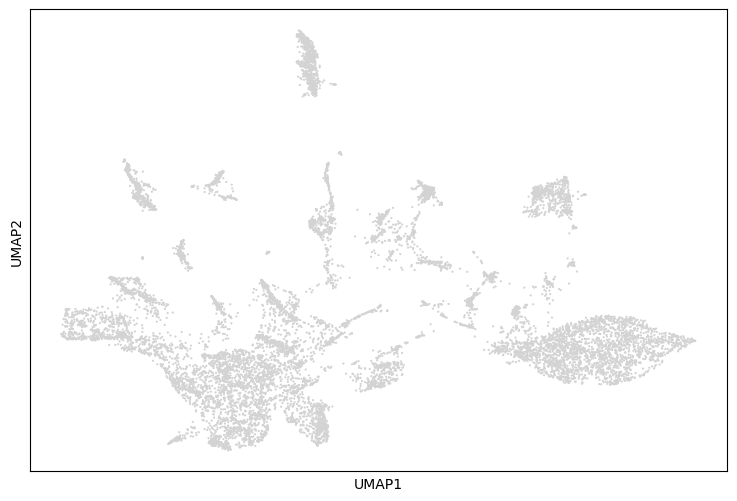

In [18]:
fig, ax = plt.subplots(figsize=(9, 6))
sc.pl.umap(adata, ax=ax)

# overcluster and merge

In [19]:
from cluster import *

In [20]:
sc.tl.leiden(adata, resolution=2)

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


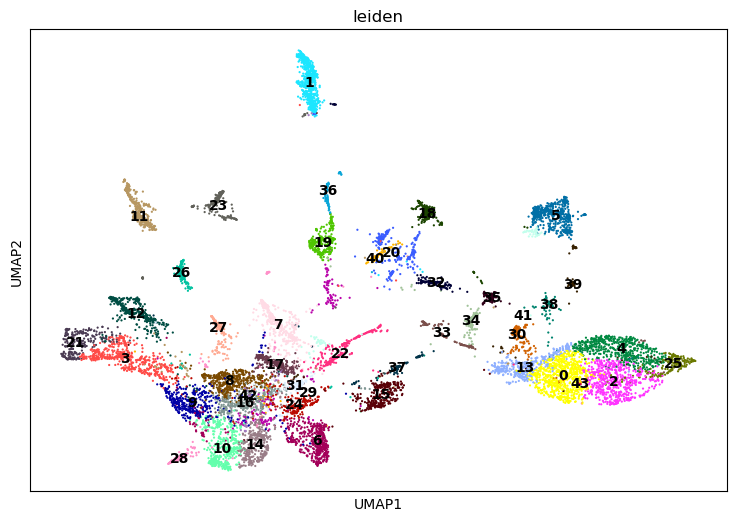

In [21]:
fig, ax = plt.subplots(figsize=(9, 6))
sc.pl.umap(adata, ax=ax, color="leiden", legend_loc="on data")

In [28]:
merge_clusters(adata, "leiden", num_genes=100, fold_difference=5)

In [ ]:
merge_

/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/miniforge/base/envs/ascc24/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


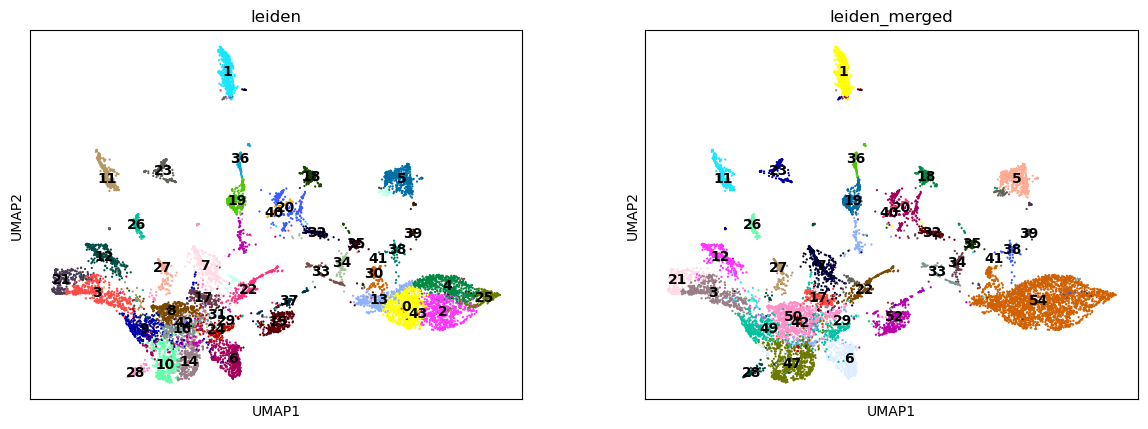

In [29]:
sc.pl.umap(adata, color=["leiden", "leiden_merged"], legend_loc="on data")

In [32]:
adata.obs["leiden"].value_counts().shape, adata.obs["leiden_merged"].value_counts().shape

((44,), (33,))

In [35]:
sc.tl.dendrogram(adata, groupby="leiden_merged")

In [36]:
paper_markers = ["Ptgds", "Rgs5", "Pecam1", "Opalin", "Mog", "Pdgfra", "Cx3cr1", "Acsbg1", "Vip",
    "Sst", "Pvalb", "Lamp5", "Gad2", "Dlx6os1", "Foxp2", "Rorb", "Il1rapl2", "Arhgap15", "Pld5",
    "Slc17a7", "Snap25",]

In [52]:
adata.layers["zscore"] = sc.pp.scale(adata, copy=True)

In [53]:
sc.pl.dotplot(adata, var_names=paper_markers, groupby="leiden_merged", swap_axes=True, cmap="magma_r", dendrogram=True, layer="zscore")

KeyboardInterrupt: 